In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
# import seaborn as sns
from pyik.mplext import ViolinPlot
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import sqlite3

from pyik.mplext import ViolinPlot
from util_general import QuickSlicePlot

In [2]:
posts_path = "/home/alex/data/stackexchange/overflow/caches/posts.db"
meta_path = "/home/alex/data/stackexchange/overflow/caches/posts_2017.hdf5"
word_dict_path = "./dictionaries/words_2017.hdf5"
word_list_path = "./words/features_2017.hdf5"

In [3]:
conn = sqlite3.connect(posts_path)

In [4]:
store_meta = pd.HDFStore(meta_path, "r", complib="blosc", complevel=9)
store_dict = pd.HDFStore(word_dict_path, "r", complib="blosc", complevel=9)
store_feat = pd.HDFStore(word_list_path, "r", complib="blosc", complevel=9)

In [45]:
del qs

In [5]:
smask = store_meta.select_as_coordinates("posts", "PostTypeId == 1")
qs = store_meta.select("posts", where=smask)
qs.set_index("Id", inplace=True, drop=False)
print qs.shape

(1696819, 21)


In [6]:
answers = store_meta.select("posts", where=store_meta.select_as_coordinates("posts", "PostTypeId == 2"))
answers.set_index("Id", inplace=True, drop=False)
print answers.shape

(2028240, 21)


In [7]:
words = store_dict.select("all")

words["freqs"] = words.n * 1. / words.n.sum()
words = words.sort_values(by="n", ascending=False)
words["order"] = np.arange(1, words.shape[0] + 1)
# drop known nuisance words that made it into the list
words = words.drop(544765)
words = words.drop(430514)

In [8]:
features = store_feat.select("words")
features.set_index("Id", inplace=True, drop=False)

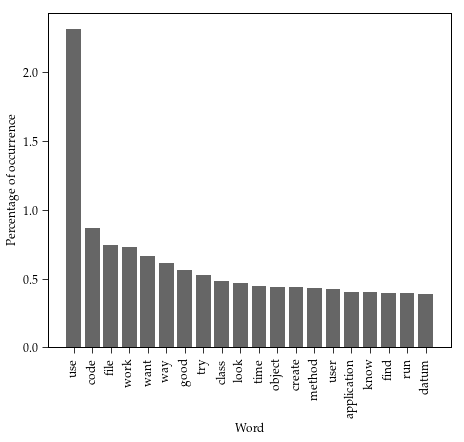

In [9]:
first = words.iloc[:20]
plt.figure(figsize=(8,6))
plt.xlabel(r"Word")
plt.ylabel(r"Percentage of occurrence")
plt.bar(np.arange(1, first.shape[0] + 1), first.n.values * 100. / words.n.sum(), 
        align="center", color="k", alpha=0.6)
plt.xticks(np.arange(1, first.shape[0] + 1), first.words.values, rotation=90)
plt.savefig("./plots/mostcommonwords.pdf")

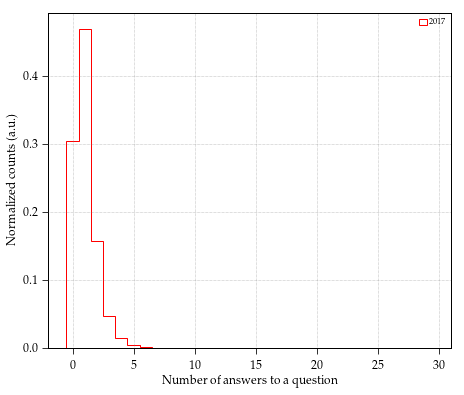

In [10]:
# did the number of answers change with time?
plt.figure(figsize=(8,6))
plt.xlabel(r"Number of answers to a question")
plt.ylabel("Normalized counts (a.u.)")
qs.AnswerCount.hist(range=[-0.5, 29.5], bins=30, color="r", normed=True, histtype="step", label="2017", axes=plt.gca())
plt.legend(loc="best")
plt.savefig("./plots/nanswers_time.pdf")

In [11]:
qs.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount'],
      dtype='object')

In [12]:
# convert to datetime objects
datecols = ["CreationDate"]
for datecol in datecols:
    qs[datecol] = pd.to_datetime(qs[datecol], origin="julian", unit="D")

In [ ]:
features

In [ ]:
# check a single (or multiple) posts
conn.execute("SELECT * FROM posts WHERE id=?", (158743,)).fetchall()

In [13]:
# join in information about occurring words, probabilities etc
qs = qs.join(features, how="inner", rsuffix="_r")
qs.head()

,AcceptedAnswerId,AnswerCount,BodyNCodes,BodyNQMarks,BodySize,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,...,Tags,Title,ViewCount,Id_r,hot_indices,nwords,ordersum,prob_bern,prob_poiss,ratio
Id,,,,,,,,,,,,,,,,,,,,,
41412454,-1,0,2,1,1635,-1.0,6,-1.0,2017-01-01 00:00:04.492800,-1,...,;postgresql;grails;gsp,Update on 2 or more tables,78,41412454,1;3;5;7;15;16;25;31;39;44;51;82;93;120;128;173...,34,9808,8.207604e-35,1.379798e-45,0.473684
41412456,41412707,1,5,1,1022,-1.0,2,-1.0,2017-01-01 00:00:39.744000,-1,...,;python;shell;expect,A expect script with multiple shell statements,52,41412456,1;5;7;8;9;20;21;26;29;32;35;40;106;116;177;235...,41,11612,7.156278e-38,4.739314e-50,0.571429
41412462,-1,1,6,2,5680,-1.0,0,-1.0,2017-01-01 00:02:06.748800,-1,...,;angularjs;provider;hybrid,While bootstrapping a hybrid angular 1 + 2 app...,205,41412462,2;18;25;29;34;53;65;73;74;76;84;106;112;113;13...,177,29357,3.510274e-47,1.470589e-171,0.206186
41412463,41412502,1,7,1,834,-1.0,4,-1.0,2017-01-01 00:02:29.817600,-1,...,;javascript;node.js,Is Javascript's setInterval killed when the pa...,76,41412463,1;3;10;14;28;29;72;90;92;117;141;270;443;457;5...,30,11140,6.456232e-34,4.154225e-43,0.352941
41412466,-1,0,7,0,3600,-1.0,0,-1.0,2017-01-01 00:03:28.569600,-1,...,;android;dataset;adapter;android-adapter;chang...,Adapter not notifyDataSetChanged immediately?,35,41412466,2;5;17;20;21;23;31;44;58;80;82;108;112;119;189...,42,14821,2.230625e-34,2.098941e-63,0.789474


In [14]:
qs["Tags"] = qs.Tags.apply(lambda x: x.split(";")[1:])
qs["hasAnswers"] = qs.AnswerCount > 1

In [15]:
# check available info
qs.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'Id_r',
       u'hot_indices', u'nwords', u'ordersum', u'prob_bern', u'prob_poiss',
       u'ratio', u'hasAnswers'],
      dtype='object')

In [16]:
now = pd.Timestamp.now()
print now

2017-10-25 11:54:50.862249


In [17]:
qs["dt_created"] = now - qs.CreationDate

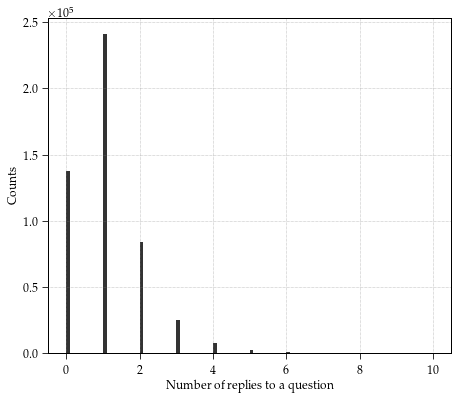

In [18]:
plt.figure(figsize=(8,6))
plt.xlabel(r"Number of replies to a question")
plt.ylabel(r"Counts")
qs.AnswerCount.hist(bins=100, range=(0, 10), color="k", alpha=0.8)
plt.savefig("./plots/naswers_hist.pdf")

/home/alex/auger/coding/utilities/util_general.py:563: RuntimeWarning: invalid value encountered in log10
  max(2 - np.floor(np.abs(np.log10(ztrafo(zedgs[i])))), 0), 2)


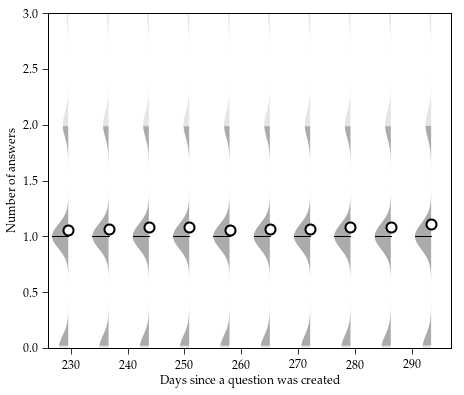

In [19]:
plt.figure(figsize=(8,6))
plt.xlabel(r"Days since a question was created")
plt.ylabel(r"Number of answers")
QuickSlicePlot(qs.dt_created.dt.days, qs.AnswerCount, qs.Score, zbins=1, xbins=10, 
               yrange=[0, 3], axes=plt.gca(), outliers=False)
plt.savefig("./plots/nanswers_vs_dt.pdf")

In [20]:
# cutting on too short questions because metrics are not working for those (yet)
qs = qs[qs.nwords > 5]

In [21]:
print len(qs)

495285


In [22]:
# shuffling the df to avoid time dependencies for now
from sklearn.utils import shuffle
qs = shuffle(qs)
print len(qs)

495285


In [23]:
# join information about first answer into the frame
# RUN ONLY ONCE or results in duplicate rows
qs = qs.merge(answers, how="left", left_on="Id", right_on="ParentId", suffixes=("", "_a"))
print qs.head()

   AcceptedAnswerId  AnswerCount  BodyNCodes  BodyNQMarks  BodySize  \
0                -1            1           2            3       901   
1          41895867            1          10            1      1735   
2                -1            0           0            1       402   
3                -1            1           1            4      2052   
4                -1            0           2            2     17330   

     ClosedDate  CommentCount  CommunityOwnedDate               CreationDate  \
0 -1.000000e+00             0                -1.0 2017-01-20 17:10:55.488000   
1 -1.000000e+00             1                -1.0 2017-01-27 12:48:25.286400   
2  2.457755e+06             0                -1.0 2017-01-01 02:51:21.254400   
3 -1.000000e+00             2                -1.0 2017-02-07 16:23:52.972800   
4 -1.000000e+00             2                -1.0 2017-01-14 10:32:51.072000   

   FavoriteCount     ...      LastActivityDate_a  LastEditDate_a  \
0             -1     ...

In [25]:
qs["CreationDate_a"] = pd.to_datetime(qs.CreationDate_a, origin="julian", unit="D")

In [26]:
# time between questions posing and first answer
dtanswer = qs.CreationDate_a - qs.CreationDate

In [27]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time between question and answer")
plt.ylabel(r"Counts")
plt.hist(dtanswer, bins=100, color="k", alpha=0.8)
plt.savefig("./plots/dtanswer_hist.pdf")

count                      531129
mean       4 days 19:10:11.643834
std       22 days 09:47:44.240422
min      -1 days +05:13:42.067200
25%        0 days 00:11:27.052800
50%        0 days 00:40:35.702400
75%        0 days 06:26:01.939200
max      237 days 05:34:29.078400
dtype: object

In [32]:
# scikitlearn import
from sklearn import base
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from scipy import stats
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [33]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        return X[self.col_names]

In [34]:
from collections import Counter

class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        a = X.Tags.apply(Counter)
        return a

In [ ]:
pipe_tags = Pipeline([
        ("cst", ColumnSelectTransformer(["Tags"])),
        ("dec", DictEncoder()),
        ("dvec", DictVectorizer(sparse=False)),
        ("tfid", TfidfTransformer()),
#        ("poly", PolynomialFeatures(degree=2)),  # not working???
        ("ridge", Ridge(alpha=10.0))
#        ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
#        ("svr", SVR())
    ])

pipe_tags.fit(qs.iloc[:10000], qs.AnswerCount.iloc[:10000])
pred = pipe_tags.predict(qs08.iloc[-5000:])
print np.column_stack((pred, qs08.AnswerCount.iloc[-5000:]))
print pipe_tags.score(qs08.iloc[-5000:], qs08.AnswerCount.iloc[-5000:])

In [ ]:
from sklearn.pipeline import FeatureUnion

#union = FeatureUnion([
#        ("city", EstimatorTransformer(city_est)),
#        ("latlong", EstimatorTransformer(pipe_latlong)),
#        ("attribute", EstimatorTransformer(pipe_attribute)),
#        ("category", EstimatorTransformer(pipe_category))
#    ])

In [ ]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

In [ ]:
qs08.columns

In [ ]:
pipe_f = Pipeline([
        ("cst", ColumnSelectTransformer(["BodyNCodes", "BodyNQMarks", "BodySize", "nwords", "ratios"])),
        ("poly", PolynomialFeatures(degree=3)),
        ("ridge", Ridge(alpha=10.0))
#        ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
#        ("svr", SVR())
    ])

pipe_f.fit(qs08.iloc[:10000], qs08.AnswerCount.iloc[:10000])
pred = pipe_f.predict(qs08.iloc[-5000:])
print np.column_stack((pred, qs08.AnswerCount.iloc[-5000:]))
print pipe_f.score(qs08.iloc[-5000:], qs08.AnswerCount.iloc[-5000:])

print compute_error(pipe_f, qs08, qs08.AnswerCount)

In [ ]:
plt.plot(qs08.probs, qs08.AnswerCount, "k.")